In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from datetime import datetime, timedelta
from src.github_api import ReplicationCode

# GitHub API

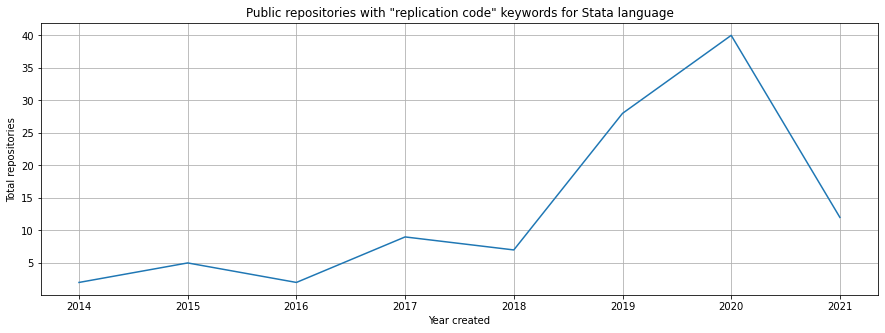

In [2]:
rc = ReplicationCode()
ghapi = rc.dataframe()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('created_at', 'count', data=ghapi)
plt.grid(b=True)
plt.title('Public repositories with "replication code" keywords for Stata language')
plt.xlabel('Year created')
plt.ylabel('Total repositories')
plt.savefig('img/replication-code-stata.png', bbox_inches = 'tight')

# AEA Deposits on ICPSR 

In [3]:
# check whether all data have been downloaded
!python3 src/aea.py --help
!python3 src/aea.py -j aer
!python3 src/aea.py -j aeri
!python3 src/aea.py -j app
!python3 src/aea.py -j pol
!python3 src/aea.py -j mac
!python3 src/aea.py -j mic
!python3 src/aea.py -j jel
!python3 src/aea.py -j jep
!python3 src/aea.py -j pandp

usage: aea.py [-h] [-j]

optional arguments:
  -h, --help       show this help message and exit
  -j , --journal   Journal name: ['aer', 'aeri', 'app', 'pol', 'mac', 'mic',
                   'jel', 'jep', 'pandp']
2021-04-14 17:53:50: https://www.aeaweb.org/journals/aer/issues
2021-04-14 17:53:53: https://www.aeaweb.org/journals/aeri/issues
2021-04-14 17:53:56: https://www.aeaweb.org/journals/app/issues
2021-04-14 17:53:59: https://www.aeaweb.org/journals/pol/issues
2021-04-14 17:54:02: https://www.aeaweb.org/journals/mac/issues
2021-04-14 17:54:04: Issue /issues/105 -> https://www.aeaweb.org/articles?id=10.1257/mac.1.2.i
2021-04-14 17:54:06: Issue /issues/105 -> https://www.aeaweb.org/articles?id=10.1257/mac.1.2.1
2021-04-14 17:54:08: Issue /issues/105 -> https://www.aeaweb.org/articles?id=10.1257/mac.1.2.29
2021-04-14 17:54:09: Issue /issues/105 -> https://www.aeaweb.org/articles?id=10.1257/mac.1.2.55
2021-04-14 17:54:11: Issue /issues/105 -> https://www.aeaweb.org/articles?id=10.12

In [4]:
aea = os.listdir('data/aea')

In [5]:
def dataframe(file):
    with open(f'data/aea/{file}', 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data['article'])
    df.insert(0, 'issue_url', data['issue_url'])
    df.insert(1, 'publication_date', data['publication_date'])

    return df

In [6]:
df = pd.concat([dataframe(x) for x in aea], sort=False)
df = df.reset_index(drop=True)
df.publication_date = df.publication_date.apply(lambda x: datetime.strptime(x, '%B %Y'))
df['year'] = df.publication_date.apply(lambda x: x.year)
df['year'] = df.year.astype(str)

ValueError: time data 'Winter 2016' does not match format '%B %Y'

In [ ]:
size = df.groupby('year')['icpsr'].size()
count = df.groupby('year')['icpsr'].count()
icpsr = pd.merge(size, count, on='year')
icpsr['proportion'] = icpsr.icpsr_y / icpsr.icpsr_x
icpsr = icpsr.reset_index()

In [ ]:
def monthly():
    # will be used for monthly
    dates = []
    base_date = icpsr.publication_date.min()
    while base_date <= icpsr.publication_date.max():
        if base_date.day == 1:
            dates.append(base_date)
        base_date += timedelta(days=1)
    datesdf = pd.DataFrame(sorted(dates), columns=['publication_date'])

    icpsr = pd.merge(datesdf, icpsr, how='left', on='publication_date')
    icpsr.percent = icpsr.percent.fillna(0)
    
    return icpsr

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('year', 'proportion', data=icpsr)
plt.grid(b=True)
plt.title('Yearly proportions of AEA papers that have deposits in ICPSR')
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.savefig('img/aea-deposit-icpsr.png', bbox_inches = 'tight')